# Path Planning In the Environments with Dynamic Obstacles

In this work we consider the problem of finding a (shortest) path in the environments with dynamic obstacles. The environment is represented by a grid composed of the free and blocked cells. The trajectories of dynamic obstacles are known and represented as a sequence of occupied cells in each time moment.

For simplicity it's assumed that the agent and dynamic obstacles can perform cardinal-only moves. They can also perform a wait action. All the actions have equal duration, so it's possible to discretize the timeline saying that at each time step the agent and dynamic obstacles can either move to one of the cardinal-adjacent cells or to stay in the same cell performing a wait-action.

The search-space state is described by tuple `(i, j, t)` where `i` and `j` are the cell's coordinates, `t` - time moment. So now theoretically there are an inifinite number of states corresponding to the same grid cell.

In [ ]:
import copy
import math
import matplotlib.pyplot as plt
import numpy as np
from heapq import heappop, heappush, heapify
from random import randint
import time
from IPython.display import HTML
from PIL import Image, ImageDraw, ImageOps
from IPython.display import Image as Img
from IPython.display import display
from sys import float_info


EPS = float_info.epsilon
%matplotlib notebook

## Grid Map Representation

In [ ]:
class Map:
    '''
    Square grid map class represents the environment for our moving agent
        - width -- the number of columns in the grid
        - height -- the number of rows in the grid
        - cells -- the binary matrix, that represents the grid. 0 - cell is traversable, 1 - cell is blocked
    '''

    def __init__(self):
        '''
        Default constructor
        '''

        self._width = 0
        self._height = 0
        self._cells = []
    

    def read_from_string(self, cell_str, width, height):
        '''
        Converting a string (with '#' representing obstacles and '.' representing free cells) to a grid

        Parameters
        ----------
        cell_str : str
            String which contains map data
        width : int
            Number of grid columns
        height : int
            Number of grid rows
        '''
        self._width = width
        self._height = height
        self._cells = [[0 for _ in range(width)] for _ in range(height)]
        cell_lines = cell_str.split("\n")
        i = 0
        j = 0
        for l in cell_lines:
            if len(l) != 0:
                j = 0
                for c in l:
                    if c == '.':
                        self._cells[i][j] = 0
                    elif c == '#' or c == 'T' or c == '@':
                        self._cells[i][j] = 1
                    else:
                        continue
                    j += 1
                if j != width:
                    raise Exception("Size Error. Map width = ", j, ", but must be", width )
                
                i += 1

        if i != height:
            raise Exception("Size Error. Map height = ", i, ", but must be", height )
    

    def set_grid_cells(self, width, height, grid_cells):
        '''
        Initialization of map by list of cells.

        Parameters
         ----------
        width : int
            Number of grid columns
        height : int
            Number of grid rows
        grid_cells : list[list[int]]
            Map matrix consisting of values of two types: 0 (traversable cells) and 1 (obstacles)
        '''

        self._width = width
        self._height = height
        self._cells = grid_cells


    def in_bounds(self, i, j):
        '''
        Check if the cell is on a grid.

        Parameters
        ----------
        i : int
            The number of the column in which the cell is located
        j : int
            The number of the row in which the cell is located

        Returns
        -------
        bool
            Is the cell inside map bounds
        '''
        return (0 <= j < self._width) and (0 <= i < self._height)
    
    def traversable(self, i, j):
        '''
        Check if the cell is not an obstacle.

        Parameters
        ----------
        i : int
            The number of the column in which the cell is located
        j : int
            The number of the row in which the cell is located

        Returns
        -------
        bool
            Is the cell traversable (true) or obstacle (false)
        '''

        return not self._cells[i][j]


    def get_neighbors(self, i, j):
        '''
        Returns a list of neighbouring cells as (i, j) tuples. 
        Fucntions should returns such neighbours, that allows only cardinal moves, 
        but dissalows cutting corners and squezzing. 

        Parameters
        ----------
        i : int
            The number of the column in which the cell is located
        j : int
            The number of the row in which the cell is located

        Returns
        -------
        neighbours : list[tuple[int, int]]
            List of neighbours grid map (i, j) coordinates
        '''

        neighbors = []
        delta = [[0, 1], [1, 0], [0, -1], [-1, 0]]

        for d in delta:
            if self.in_bounds(i + d[0], j + d[1]) and self.traversable(i + d[0], j + d[1]):
                neighbors.append((i + d[0], j + d[1]))
                
        return neighbors

    def get_size(self):
        '''
        Returns the size of the map in cells

        Returns
        -------
        tuple[int, int]
            Size of the map in cells (height, width)
        '''
        return (self._height, self._width)


### Search Node Representation



In [ ]:
class Node:
    '''
    Node class represents a search node

    - i, j: coordinates of corresponding grid element
    - g: g-value of the node (also equals time moment when the agent reaches the cell)
    - h: h-value of the node // always 0 for Dijkstra
    - f: f-value of the node // always equal to g-value for Dijkstra
    - parent: pointer to the parent-node 

    '''
    

    def __init__(self, i, j, g = 0, h = 0, f = None, parent = None):
        self.i = i
        self.j = j
        self.g = g
        self.h = h
        if f is None:
            self.f = self.g + h
        else:
            self.f = f        
        self.parent = parent

        
    
    def __eq__(self, other):
        '''
        Estimating where the two search nodes are the same,
        which is needed to detect dublicates in the search tree.
        '''
        return (self.i == other.i) and (self.j == other.j) and (self.g == other.g)
    
    def __hash__(self):
        '''
        To implement CLOSED as set of nodes we need Node to be hashable.
        '''
        return hash(self.i * self.j * self.g)


    def __lt__(self, other): 
        '''
        Comparison between self and other. Returns is self < other (self has higher priority).
        '''
        return self.f < other.f or ((self.f == other.f) and (self.h < other.h))

### Implementing the search tree (i.e. OPEN,  CLOSED)

 

In [ ]:
class SearchTree: #SearchTree which uses PriorityQueue for OPEN and set for CLOSED
    '''
    Efficient implementation of the search tree (OPEN and CLOSED) is crucial for any search algorithm. 
    You should use your efficient implementation of the search tree that you've created in the previous labs).
    '''
    def __init__(self):
        self._open = []   
        self._closed = set([])         
        self._enc_open_dublicates = 0 
                                      
    def __len__(self):
        return len(self._open) + len(self._closed)
                
    def open_is_empty(self):
        '''
        open_is_empty should inform whether the OPEN is exhausted or not.
        In the former case the search main loop should be interrupted.
        '''
        return len(self._open) == 0
    
 
    def add_to_open(self, item):
        '''
        Adding a (previously not expanded) node to the search-tree (i.e. to OPEN).
        It's either a totally new node (the one we never encountered before)
        or it can be a dublicate of the node that currently resides in OPEN.
        It's up to us how to handle dublicates in OPEN. We can either 
        detect dublicates upon adding (i.e. inside this method) or detect them
        lazily, when we are extracting a node for further expansion.
        Not detecting dublicates at all may work in certain setups but let's not
        consider this option.
        '''   
        heappush(self._open, item)
    

    def get_best_node_from_open(self):
        '''
        Extracting the best node (i.e. the one with the minimal key) from OPEN.
        This node will be expanded further on in the main loop of the search.
        ''' 
        res = heappop(self._open)
        return res

    def add_to_closed(self, item):
        self._closed.add(item)

    def was_expanded(self, item):
        return item in self._closed

    @property
    def opened(self):
        return self._open
    
    @property
    def expanded(self):
        return self._closed

    @property
    def number_of_open_dublicates(self):
        return self._enc_open_dublicates


### A* with Timesteps


In [ ]:
def manhattan_distance(i1, j1, i2, j2):
    '''
    Returns a manhattan distance between two cells

    Parameters
    ----------
    i1, j1 : int, int
        Position of first cell on the grid map
    i2, j2 : int, int
        Position of second cell on the grid map

    Returns
    -------
    int
        Manhattan distance between two cells

    '''
    return abs(i1 - i2) + abs(j1 - j2)

In [ ]:
def compute_cost(i1, j1, i2, j2):
    '''
    Computes cost of simple moves

    Parameters
    ----------
    i1, j1 : int, int
        Position of first cell on the grid map
    i2, j2 : int, int
        Position of second cell on the grid map

    Returns
    -------
    int
        Cost of the move between two neighbouring cells

    '''

    d = abs(i1 - i2) + abs(j1 - j2)
    if d == 0:  # wait
        return 1
    elif d == 1:  # cardinal move
        return 1
    else:
        raise Exception('Trying to compute the cost of non-supported move!')

In [ ]:
class CATable:
    '''
    Class, which implements collision avoidance table for effective checking collisions with dynamic obstacles
    '''
    def __init__(self, dyn_obst_traj):       
        self.pos_time_table = dict()
        self.max_time_table = dict()
        
        for obst_id, obstacle in enumerate(dyn_obst_traj):
            for t, (i, j) in enumerate(obstacle):
                self.pos_time_table[(i, j, t)] = obst_id
            
            self.max_time_table[obstacle[-1]] = len(obstacle) - 1 
            
    def __check_pos_at_time(self, i, j, t):
        '''
        Checks, that cell (i, j) is occupied at moment t
        
        Parameters
        ----------
        i, j: int, int
            Position of cell on the grid map
        t : int
             Time moment to check
            
        Returns
        -------
        bool
            False, if cell is occupied at time moment t
            True, if not occupied at time moment t
        '''
        return (i, j, t) not in self.pos_time_table.keys()
                
    def __check_rev_move(self, i1, j1, i2, j2, t_start):
        '''
        Checks, that the given move does not result in edge collision
        
        Parameters
        ----------
        i1, j1 : int, int
            Start cell of the move
        i2, j2 : int, int
            Target cell of the move
        t_start : int
             Time when the move starts
            
        Returns
        -------
        bool        
            True if the given move does not result in the edge collision
            False if the given move does results in the edge collision
        '''
        if (i1, j1, t_start+1) in self.pos_time_table.keys() and (i2, j2, t_start) in self.pos_time_table.keys():
            return not (self.pos_time_table[(i2, j2, t_start)] == self.pos_time_table[(i1, j1, t_start+1)])
        return True

    def check_move(self, i1, j1, i2, j2, t_start):
        '''
        Checks if the move between (i1, j1) and (i2, j2) 
        at moment (t_start -> t_start+1) leads 
        to the collision with a dynamic obstacle.

        Parameters
        ----------
        i1, j1 : int, int
            Start cell of the move
        i2, j2 : int, int
            Target cell of the move
        t_start : int
             Time step when the move starts
            
        Returns
        -------
        bool
            Is the move valid (true) or will it lead to a collision (false)
        '''
        return self.__check_rev_move(i1, j1, i2, j2, t_start) and self.__check_pos_at_time(i2, j2, t_start+1)

In [ ]:
def get_neighbors_wrt_time(i, j, t, grid_map, ca_table):
    '''
    Returns a list of neighbouring cells as (i, j) tuples. 
    
    Should return such neighbours, that result
    from non-colliding actions (cardinal moves and wait) w.r.t.
    the given time step.
    
    I.e. the succesor cell should be free at the next time step,
    as well at the move should not result in the edge collision.
    
    Parameters
    ----------
    i, j : int
        Cell coordinates
    grid_map : Map
        An additional domain information (such as grid map).
    ca_table : CATable
        Collision avoidance table

    Returns
    -------
    neighbours : list[tuple[int, int]]
        List of neighbours grid map (i, j) coordinates
    '''

    neighbors = grid_map.get_neighbors(i, j)
    neighbors.append((i, j))
    result = []
    for node in neighbors:
        if ca_table.check_move(i, j, node[0], node[1], t):
            result.append(node)
    return result

In [ ]:
def astar_timesteps(grid_map, ca_table, start_i, start_j, goal_i, goal_j, heuristic_func = None, search_tree = None):
    '''
    Runs A* search algorithm without re-expansion on dynamic obstacles domain.

    Parameters
    ----------
    grid_map : Map
        An additional domain information (such as grid map).
    ca_table : CATable
        Collision avoidance table
    start_i, start_j : int, int
        Start cell
    goal_i, goal_j  : int, int
        Goal cell
    heuristic_func : function
        Heuristic function
    search_tree : type 
        Search tree data structure

    Returns
    -------
    path_found : bool
        Path was found or not.  
    last_node : Node
        The last node in path. None if path was not found.
    steps : int
        The number of search steps
    noodes_created : int
        The number of nodes, which were created and stored during the search process (size of the resultant search tree)
    open : iterable object
        Iterable collection of OPEN nodes
    expanded : iterable object
        Iterable collection of the expanded nodes
    '''
    ast = search_tree()
    steps = 0
    nodes_created = 0

    start_node = Node(start_i, start_j, g=0, h=heuristic_func(start_i, start_j, goal_i, goal_j))
    ast.add_to_open(start_node)

    while not ast.open_is_empty():
        cur_node = ast.get_best_node_from_open()
        steps += 1
        if cur_node.i == goal_i and cur_node.j == goal_j:
            cur_node.g = cur_node.parent.g + compute_cost(cur_node.parent.i, cur_node.parent.j, cur_node.i, cur_node.j)
            ast.add_to_closed(cur_node)
            return True, cur_node, steps, len(ast), ast.opened, ast.expanded
       
        if not ast.was_expanded(cur_node):    
            for t in get_neighbors_wrt_time(cur_node.i, cur_node.j, cur_node.g, grid_map, ca_table):    
                if not ast.was_expanded(Node(t[0], t[1])):            
                    ast.add_to_open(Node(t[0], t[1], g=cur_node.g + compute_cost(cur_node.i, cur_node.j, t[0], t[1]), h=heuristic_func(t[0], t[1], goal_i, goal_j), parent = cur_node)) 
            ast.add_to_closed(cur_node)
    return False, None, steps, len(ast), ast.opened, ast.expanded

In [ ]:
def make_path(goal):
    '''
    Creates a path by tracing parent pointers from the goal node to the start node
    It also returns path's length.
    '''

    length = goal.g
    current = goal
    path = []
    while current.parent:
        path.append(current)
        current = current.parent
    path.append(current)
    return path[::-1], length

### Visualization

In [ ]:
def draw(grid_map, dyn_obst_traj, path, output_filename = 'animated_trajectories'):
    '''
    Auxiliary function that visualizes the environment.
    
    The function assumes that nodes_opened/nodes_expanded
    are iterable collestions of search nodes
    '''
    
    k = 30
    quality = 6
    height, width = grid_map.get_size()
    h_im = height * k
    w_im = width * k
    pathlen = len(path)
    
    step = 0
    images = []
    agent_color = randint(0, 255), randint(0, 255), randint(0, 255)
              
    while step < pathlen:
        for n in range(0, quality):
            im = Image.new('RGB', (w_im, h_im), color = 'white')
            draw = ImageDraw.Draw(im)
            
            # draw static obstacles
            for i in range(height):
                for j in range(width):
                    if(not grid_map.traversable(i, j)):
                        draw.rectangle((j * k, i * k, (j + 1) * k - 1, (i + 1) * k - 1), fill=( 70, 80, 80 ))
                   
            
            #draw agent
            curr_node = path[step]
            next_node = path[min(pathlen - 1, step + min(n, 1))]

            di = n * (next_node.i - curr_node.i) / quality
            dj = n * (next_node.j - curr_node.j) / quality

            draw.ellipse((float(curr_node.j + dj + 0.2) * k, 
                          float(curr_node.i + di + 0.2) * k, 
                          float(curr_node.j + dj + 0.8) * k - 1, 
                          float(curr_node.i + di + 0.8) * k - 1), 
                          fill=agent_color, width=0)
            
            # draw dynamic obstacles 
            for i in range(len(dyn_obst_traj)):
                curr_pos = dyn_obst_traj[i][min(len(dyn_obst_traj[i]) - 1, step)]
                next_pos = dyn_obst_traj[i][min(len(dyn_obst_traj[i]) - 1, step + min(n, 1))]
                
                di = n * (next_pos[0] - curr_pos[0]) / quality
                dj = n * (next_pos[1] - curr_pos[1]) / quality
            
                draw.rectangle((float(curr_pos[1] + dj + 0.2) * k, 
                              float(curr_pos[0] + di + 0.2) * k, 
                              float(curr_pos[1] + dj + 0.8) * k - 1, 
                              float(curr_pos[0] + di + 0.8) * k - 1), 
                              fill=(50, 50, 50), width=0)
            im = ImageOps.expand(im, border=2, fill='black')
            images.append(im)
        step += 1
    images[0].save('./'+output_filename+'.png', save_all=True, append_images=images[1:], optimize=False, duration=500/quality, loop=0)
    display(Img(filename = './'+output_filename+'.png'))

## Experimental evaluation

In [ ]:
def simple_test(search_func, task, *args):
    '''
    simple_test runs search_func on one task (use a number from 0 to 4 to 
    choose a certain debug task on simple map or None to choose a random task 
    from this pool) with *args as optional arguments and displays:
     - 'Path found!' and some statistics -- path was found
     - 'Path not found!' -- path was not found
     
    Parameters
    ----------
    search_func : function
        Function, which implements the method to run
    task : int
        Number of task from pregenerated set. Must be in the range from 0 to 4 (use None ro run random task)
    '''
    
    height = 15
    width = 30
    map_str = '''
. . . # # . . . . . . . . # # . . . # . . # # . . . . . . .  
. . . # # # # # . . # . . # # . . . . . . # # . . . . . . . 
. . . . . . . # . . # . . # # . . . # . . # # . . . . . . . 
. . . # # . . # . . # . . # # . . . # . . # # . . . . . . . 
. . . # # . . # . . # . . # # . . . # . . # # . . . . . . . 
. . . # # . . # . . # . . # # . . . # . . # # # # # . . . . 
. . . # # . . # . . # . . # # . . . # . . # # # # # . . . . 
. . . . . . . # . . # . . # # . . . # . . # . . . . . . . . 
. . . # # . . # . . # . . # # . . . # . . # . . . . . . . . 
. . . # # . . # . . # . . # # . . . # . . # . . . . . . . . 
. . . # # . . . . . # . . . . . . . # . . . . . . . . . . . 
. . . # # # # # # # # # # # # # . # # . # # # # # # # . # # 
. . . # # . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
. . . # # . . . . . . . . # # . . . . . . . . . . . . . . .
'''

    task_map = Map()
    task_map.read_from_string(map_str, width, height)
    
    starts = [(1, 28), (2, 29), (3, 20), (3, 20), (0, 0)]
    goals = [(0, 1), (6, 2), (5, 6), (13, 0), (4, 23)]
    dyn_obst_traj = []
    dyn_obst_traj.append([(12,2), (11,2), (12,2), (13,2), (14,2), (13,2), (12,2), (11,2), (12,2), (13,2), (14,2), (13,2), (12,2),(11,2), (12,2), (13,2), (14,2), (13,2), (12,2),(11,2), (12,2), (13,2), (14,2), (13,2), (12,2),(11,2), (12,2), (13,2), (14,2), (13,2), (12,2),(11,2), (12,2), (13,2), (14,2), (13,2), (12,2),(11,2), (12,2), (13,2), (14,2), (13,2), (12,2),(11,2), (12,2), (13,2), (14,2), (13,2), (12,2),(11,2), (12,2), (13,2), (14,2), (13,2), (12,2),(11,2), (12,2), (13,2), (14,2), (13,2), (12,2),(11,2), (12,2), (13,2), (14,2), (13,2), (12,2),(11,2), (12,2), (13,2), (14,2), (13,2), (12,2),(11,2), (12,2), (13,2), (14,2), (13,2), (12,2),(11,2), (12,2), (13,2), (14,2), (13,2), (12,2)])
    dyn_obst_traj.append([(13,2), (13,3), (13,2), (13,1), (13, 0), (13, 1), (13,2), (13,3), (13,2), (13,1), (13, 0), (13, 1), (13,2), (13,3), (13,2), (13,1), (13, 0), (13, 1), (13,2), (13,3), (13,2), (13,1), (13, 0), (13, 1), (13,2), (13,3), (13,2), (13,1), (13, 0), (13, 1), (13,2), (13,3), (13,2), (13,1), (13, 0), (13, 1), (13,2), (13,3), (13,2), (13,1), (13, 0), (13, 1), (13,2), (13,3), (13,2), (13,1), (13, 0), (13, 1), (13,2), (13,3), (13,2), (13,1), (13, 0), (13, 1), (13,2), (13,3), (13,2), (13,1), (13, 0), (13, 1), (13,2), (13,3), (13,2), (13,1), (13, 0), (13, 1), (13,2), (13,3), (13,2), (13,1), (13, 0), (13, 1)])    
    dyn_obst_traj.append([(1,1), (1,2), (2,2), (2,1), (1,1), (1,2), (2,2), (2,1), (1,1), (1,2), (2,2), (2,1), (1,1), (1,2), (2,2), (2,1), (1,1), (1,2), (2,2), (2,1), (1,1), (1,2), (2,2), (2,1), (1,1), (1,2), (2,2), (2,1), (1,1), (1,2), (2,2), (2,1), (1,1), (1,2), (2,2), (2,1), (1,1), (1,2), (2,2), (2,1), (1,1), (1,2), (2,2), (2,1), (1,1), (1,2), (2,2), (2,1), (1,1), (1,2), (2,2), (2,1), (1,1), (1,2), (2,2), (2,1), (1,1), (1,2), (2,2), (2,1), (1,1), (1,2), (2,2), (2,1), (1,1), (1,2), (2,2), (2,1), (1,1), (1,2), (2,2), (2,1), (1,1), (1,2), (2,2), (2,1), (1,1), (1,2), (2,2), (2,1), (1,1), (1,2), (2,2), (2,1), (1,1), (1,2), (2,2), (2,1), (1,1), (1,2), (2,2), (2,1), (1,1), (1,2), (2,2), (2,1)])
    dyn_obst_traj.append([(7,1), (7,2), (7,3), (7,4), (7,3), (7,2), (7,1), (7,2), (7,3), (7,4), (7,3), (7,2), (7,1), (7,2), (7,3), (7,4), (7,3), (7,2), (7,1), (7,2), (7,3), (7,4), (7,3), (7,2), (7,1), (7,2), (7,3), (7,4), (7,3), (7,2), (7,1), (7,2), (7,3), (7,4), (7,3), (7,2), (7,1), (7,2), (7,3), (7,4), (7,3), (7,2), (7,1), (7,2), (7,3), (7,4), (7,3), (7,2), (7,1), (7,2), (7,3), (7,4), (7,3), (7,2), (7,1), (7,2), (7,3), (7,4), (7,3), (7,2), (7,1), (7,2), (7,3), (7,4), (7,3), (7,2), (7,1), (7,2), (7,3), (7,4), (7,3), (7,2), (7,1), (7,2), (7,3), (7,4), (7,3), (7,2), (7,1), (7,2), (7,3), (7,4), (7,3), (7,2), (7,1), (7,2), (7,3), (7,4), (7,3), (7,2), (7,1), (7,2), (7,3), (7,4), (7,3), (7,2)])
    dyn_obst_traj.append([(13,10), (13,11), (13,12), (13,13), (13,14), (13,15), (13,16), (13,17), (13,16), (13,15), (13,14), (13,13), (13,12), (13,11), (13,10), (13,11), (13,12), (13,13), (13,14), (13,15), (13,16), (13,17), (13,16), (13,15), (13,14), (13,13), (13,12), (13,11), (13,10), (13,11), (13,12), (13,13), (13,14), (13,15), (13,16), (13,17), (13,16), (13,15), (13,14), (13,13), (13,12), (13,11), (13,10), (13,11), (13,12), (13,13), (13,14), (13,15), (13,16), (13,17), (13,16), (13,15), (13,14), (13,13), (13,12), (13,11), (13,10), (13,11), (13,12), (13,13), (13,14), (13,15), (13,16), (13,17), (13,16), (13,15), (13,14), (13,13), (13,12), (13,11), (13,10), (13,11), (13,12), (13,13), (13,14), (13,15), (13,16), (13,17), (13,16), (13,15), (13,14), (13,13), (13,12), (13,11)])
    dyn_obst_traj.append([(11,16), (12,16), (12,17), (12,18), (12,19), (11,19), (12,19), (12,18), (12,17), (12,16), (11,16), (12,16), (12,17), (12,18), (12,19), (11,19), (12,19), (12,18), (12,17), (12,16), (11,16), (12,16), (12,17), (12,18), (12,19), (11,19), (12,19), (12,18), (12,17), (12,16), (11,16), (12,16), (12,17), (12,18), (12,19), (11,19), (12,19), (12,18), (12,17), (12,16), (11,16), (12,16), (12,17), (12,18), (12,19), (11,19), (12,19), (12,18), (12,17), (12,16), (11,16), (12,16), (12,17), (12,18), (12,19), (11,19), (12,19), (12,18), (12,17), (12,16), (11,16), (12,16), (12,17), (12,18), (12,19), (11,19), (12,19), (12,18), (12,17), (12,16), (11,16), (12,16), (12,17), (12,18), (12,19), (11,19), (12,19), (12,18), (12,17), (12,16), (11,16), (12,16), (12,17), (12,18), (12,19), (11,19), (12,19), (12,18), (12,17), (12,16)])
    dyn_obst_traj.append([(4,0), (4,1), (3,1), (3,0), (4,0), (4,1), (3,1), (3,0), (4,0), (4,1), (3,1), (3,0), (4,0), (4,1), (3,1), (3,0), (4,0), (4,1), (3,1), (3,0), (4,0), (4,1), (3,1), (3,0), (4,0), (4,1), (3,1), (3,0), (4,0), (4,1), (3,1), (3,0), (4,0), (4,1), (3,1), (3,0), (4,0), (4,1), (3,1), (3,0), (4,0), (4,1), (3,1), (3,0), (4,0), (4,1), (3,1), (3,0), (4,0), (4,1), (3,1), (3,0), (4,0), (4,1), (3,1), (3,0), (4,0), (4,1), (3,1), (3,0), (4,0), (4,1), (3,1), (3,0), (4,0), (4,1), (3,1), (3,0), (4,0), (4,1), (3,1), (3,0), (4,0), (4,1), (3,1), (3,0), (4,0), (4,1), (3,1), (3,0), (4,0), (4,1), (3,1), (3,0), (4,0), (4,1), (3,1), (3,0), (4,0), (4,1), (3,1), (3,0), (4,0), (4,1), (3,1), (3,0), (4,0), (4,1), (3,1), (3,0)])
    dyn_obst_traj.append([(10,20), (10, 21), (10,22), (10,23), (10,24), (10,23), (10,22), (10,21), (10,20), (10, 21), (10,22), (10,23), (10,24), (10,23), (10,22), (10,21), (10,20), (10, 21), (10,22), (10,23), (10,24), (10,23), (10,22), (10,21), (10,20), (10, 21), (10,22), (10,23), (10,24), (10,23), (10,22), (10,21), (10,20), (10, 21), (10,22), (10,23), (10,24), (10,23), (10,22), (10,21), (10,20), (10, 21), (10,22), (10,23), (10,24), (10,23), (10,22), (10,21), (10,20), (10, 21), (10,22), (10,23), (10,24), (10,23), (10,22), (10,21), (10,20), (10, 21), (10,22), (10,23), (10,24), (10,23), (10,22), (10,21), (10,20), (10, 21), (10,22), (10,23), (10,24), (10,23), (10,22), (10,21), (10,20), (10, 21), (10,22), (10,23), (10,24), (10,23), (10,22), (10,21), (10,20), (10, 21), (10,22), (10,23), (10,24), (10,23), (10,22), (10,21)])
    dyn_obst_traj.append([(12,6), (12,7), (13,7), (13,6), (12,6), (12,7), (13,7), (13,6), (12,6), (12,7), (13,7), (13,6), (12,6), (12,7), (13,7), (13,6), (12,6), (12,7), (13,7), (13,6), (12,6), (12,7), (13,7), (13,6), (12,6), (12,7), (13,7), (13,6), (12,6), (12,7), (13,7), (13,6), (12,6), (12,7), (13,7), (13,6), (12,6), (12,7), (13,7), (13,6), (12,6), (12,7), (13,7), (13,6), (12,6), (12,7), (13,7), (13,6), (12,6), (12,7), (13,7), (13,6), (12,6), (12,7), (13,7), (13,6), (12,6), (12,7), (13,7), (13,6), (12,6), (12,7), (13,7), (13,6), (12,6), (12,7), (13,7), (13,6), (12,6), (12,7), (13,7), (13,6), (12,6), (12,7), (13,7), (13,6), (12,6), (12,7), (13,7), (13,6), (12,6), (12,7), (13,7), (13,6), (12,6), (12,7), (13,7), (13,6), (12,6), (12,7), (13,7), (13,6), (12,6), (12,7), (13,7), (13,6)])
    dyn_obst_traj.append([(12,26), (12,27), (11,27), (12,27), (12,28), (12,27), (12,26), (12,27), (11,27), (12,27), (12,28), (12,27), (12,26), (12,27), (11,27), (12,27), (12,28), (12,27), (12,26), (12,27), (11,27), (12,27), (12,28), (12,27), (12,26), (12,27), (11,27), (12,27), (12,28), (12,27), (12,26), (12,27), (11,27), (12,27), (12,28), (12,27), (12,26), (12,27), (11,27), (12,27), (12,28), (12,27), (12,26), (12,27), (11,27), (12,27), (12,28), (12,27), (12,26), (12,27), (11,27), (12,27), (12,28), (12,27), (12,26), (12,27), (11,27), (12,27), (12,28), (12,27), (12,26), (12,27), (11,27), (12,27), (12,28), (12,27), (12,26), (12,27), (11,27), (12,27), (12,28), (12,27), (12,26), (12,27), (11,27), (12,27), (12,28), (12,27), (12,26), (12,27), (11,27), (12,27), (12,28), (12,27), (12,26), (12,27), (11,27), (12,27), (12,28), (12,27)])
    
    ca_table = CATable(dyn_obst_traj)
    
    lengths = [54, 47, 48, 38, 56]

    if (task is None) or not (0 <= task < 5):
        task = randint(0, 4)

    start = Node(*starts[task])
    goal = Node(*goals[task])
    true_length = lengths[task]


    result = search_func(task_map, ca_table, start.i, start.j, goal.i, goal.j, *args)
    number_of_steps = result[2]
    nodes_created = result[3]
    if result[0]:
        path, length = make_path(result[1])
        correct = (int(length)  == int(true_length))
        print("Path found! Length: " + str(length) + " correct: " + str(true_length) + 
              ". Nodes created: " + str(nodes_created) + \
              ". Number of steps: " + str(number_of_steps) + \
              ". Correct: " + str(correct))
        draw(task_map, dyn_obst_traj, path)
        
    else:
        print("Path not found!")

Path found! Length: 54 correct: 54. Nodes created: 2497. Number of steps: 5969. Correct: True


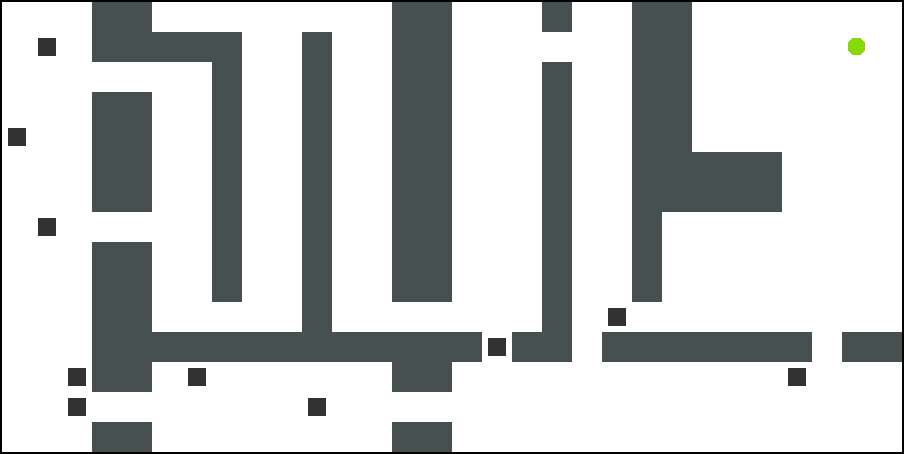

CPU times: user 5.49 s, sys: 304 ms, total: 5.79 s
Wall time: 5.79 s


In [ ]:
%time simple_test(astar_timesteps, 0, manhattan_distance, SearchTree)

Path found! Length: 47 correct: 47. Nodes created: 1839. Number of steps: 4361. Correct: True


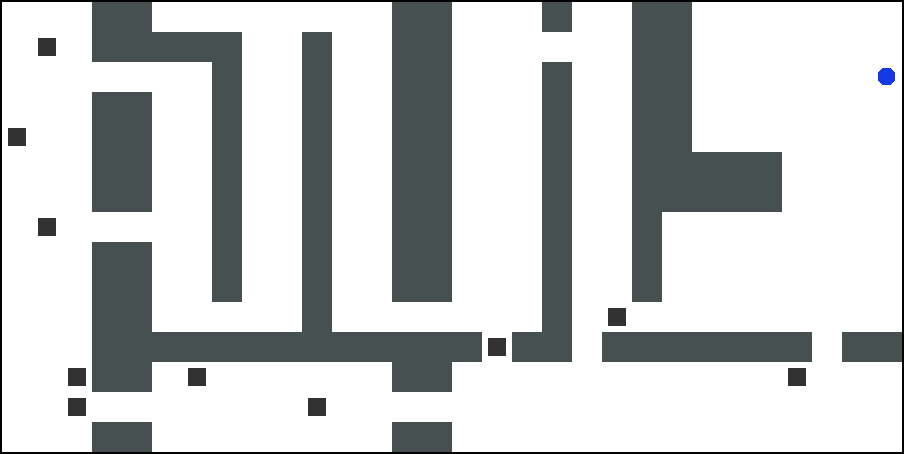

CPU times: user 4.72 s, sys: 185 ms, total: 4.9 s
Wall time: 4.98 s


In [ ]:
%time simple_test(astar_timesteps, 1, manhattan_distance, SearchTree)

Path found! Length: 48 correct: 48. Nodes created: 4031. Number of steps: 11213. Correct: True


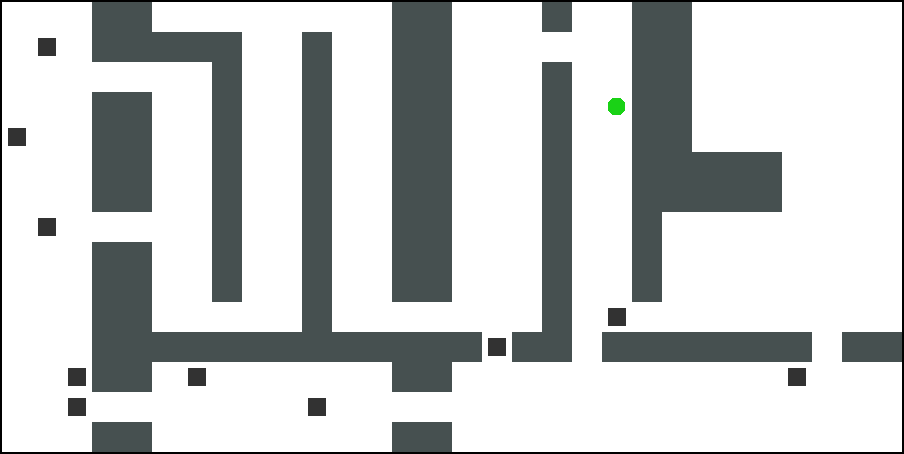

CPU times: user 5.01 s, sys: 175 ms, total: 5.19 s
Wall time: 5.26 s


In [ ]:
%time simple_test(astar_timesteps, 2, manhattan_distance, SearchTree)

Path found! Length: 38 correct: 38. Nodes created: 913. Number of steps: 1495. Correct: True


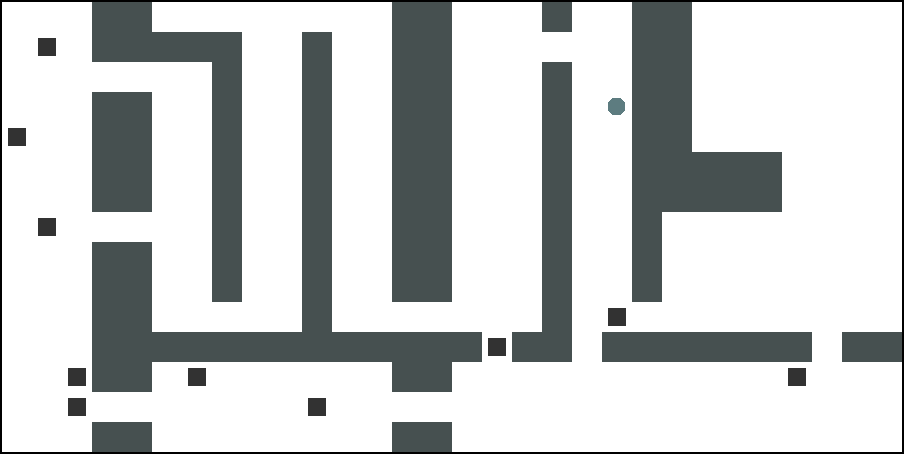

CPU times: user 3.72 s, sys: 150 ms, total: 3.87 s
Wall time: 3.9 s


In [ ]:
%time simple_test(astar_timesteps, 3, manhattan_distance, SearchTree)

Path found! Length: 56 correct: 56. Nodes created: 3706. Number of steps: 9523. Correct: True


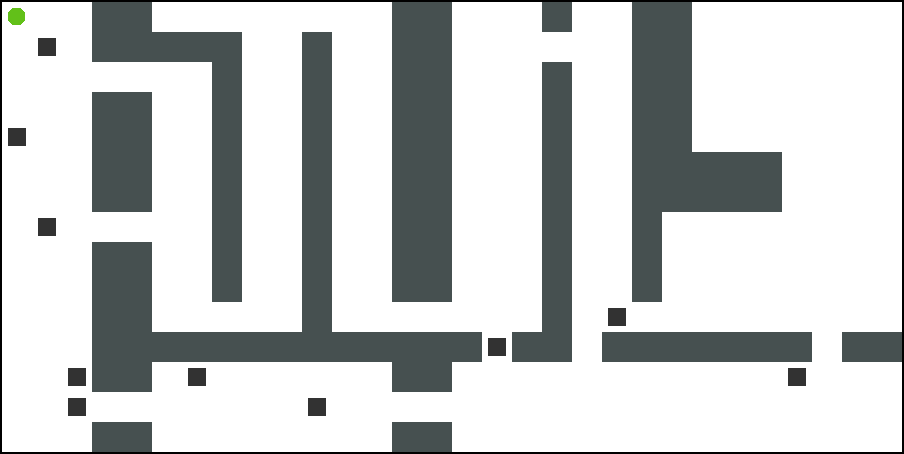

CPU times: user 5.89 s, sys: 346 ms, total: 6.23 s
Wall time: 6.26 s


In [ ]:
%time simple_test(astar_timesteps, 4, manhattan_distance, SearchTree)